In [ ]:
%load_ext autoreload
%autoreload 2

# core

> Core utilities

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import cv2
import nd2
import torch
import fastcore.all as fc

plt.rcParams['image.cmap'] = 'gray'

In [ ]:
from minai import *

## Image processing

There's no point working with videos, so let's save them as images. Something was wrong with `20mins021.nd2` file, so we won't use them. 

In [ ]:
video_path = Path.home()/'data/pili/training_videos'
video_path.ls()

(#9) [Path('/home/kappa/data/pili/training_videos/200ms-0.4%-005.nd2'),Path('/home/kappa/data/pili/training_videos/0N01002.nd2'),Path('/home/kappa/data/pili/training_videos/7.1- 003.nd2'),Path('/home/kappa/data/pili/training_videos/0.1%.004.nd2'),Path('/home/kappa/data/pili/training_videos/1hr01002.nd2'),Path('/home/kappa/data/pili/training_videos/dCpdA R1 FH 017.nd2'),Path('/home/kappa/data/pili/training_videos/4hrs incu004.nd2'),Path('/home/kappa/data/pili/training_videos/WT-A86C-LB-ice-002.nd2'),Path('/home/kappa/data/pili/training_videos/Chp B Replicate 2 200 MS060.nd2')]

Let's take a look at the first video.

In [ ]:
vp = video_path.ls()[0]
vp

Path('/home/kappa/data/pili/training_videos/200ms-0.4%-005.nd2')

For each video, we want to only use the first frame for now. This is what it looks like:

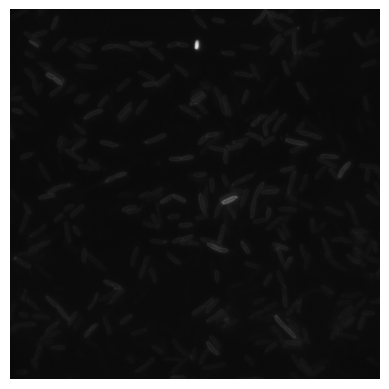

In [ ]:
with nd2.ND2File(vp) as nd2_file:
    first_frame = nd2_file.read_frame(0)
    plt.imshow(first_frame)
    plt.axis('off') 

Now we turn the video into an image.

In [ ]:
def save_first_frame(input_path, output_path, extension = '.png') -> None:
    """
    Save the first frame of an ND2 file as an image, using the same name as input file.
    """
    filename = input_path.name.removesuffix('.nd2')  # Some names have . in the filename
    output_path = (output_path/f'{filename}{extension}')
    Image.fromarray(nd2.imread(input_path)[0]).save(output_path)

In [ ]:
# Save videos as images
# for p in video_path.ls(): 
#     if p.suffix == '.nd2': save_first_frame(p, path)

In [ ]:
path = Path.home()/'data/pili/training_data'
path.ls()

(#18) [Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.png'),Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.png'),Path('/home/kappa/data/pili/training_data/1hr01002.csv'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.png'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.png'),Path('/home/kappa/data/pili/training_data/4hrs incu004.csv'),Path('/home/kappa/data/pili/training_data/7.1- 003.png'),Path('/home/kappa/data/pili/training_data/4hrs incu004.png'),Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.csv'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv'),Path('/home/kappa/data/pili/training_data/0.1%.004.png'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.csv'),Path('/home/kappa/data/pili/training_data/0N01002.csv'),Path('/home/kappa/data/pili/training_data/0N01002.png'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.csv'),Path('/home/kappa/data/pili/training_data/7.1- 0

In [ ]:
#| export
@fc.delegates(plt.Axes.imshow)
def show_im(path, figsize=(10, 8), **kwargs):
    """Show an image from the path."""
    plt.figure(figsize=figsize)
    plt.imshow(Image.open(path), **kwargs)
    plt.axis('off')

We can now use `show_im` to display images.

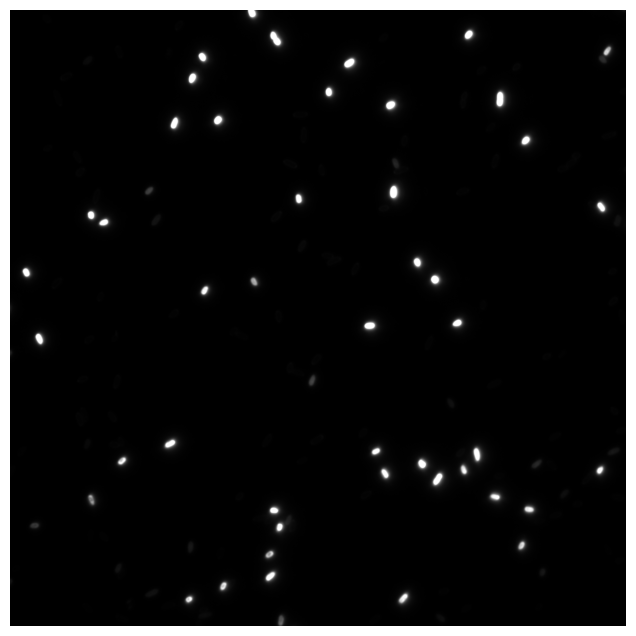

In [ ]:
img_path = path/'0N01002.png'
im = np.array(Image.open(img_path))
show_image(im, figsize=(8,8));

Now, we want to take care of bounding boxes. We first turn them into YOLO format because they are in angle format.

YOLO format:
```
'class_index', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'
```
where `x1`, ..., `y4` are edge points for each box.

csv files have information about the box. `Length`, `Width`, `Position X` and `Position Y` are in nanometer(?).

In [ ]:
df = pd.read_csv(path/'0N01002.csv')
df.head()

,Name,Length,Width,Angle,Position X,Position Y,Color R,Color G,Color B,Type
0,Box 1,2.100000e-06,0.000001,0.733038,0.000011,0.000082,0.509804,0.901961,0.509804,1
1,Box 2,2.300000e-06,0.000001,0.401426,0.000015,0.000083,0.509804,0.901961,0.509804,1
2,Box 3,2.000000e-06,0.000001,0.837758,0.000013,0.000072,0.509804,0.901961,0.509804,1
3,Box 4,2.100000e-06,0.000001,1.832596,0.000029,0.000075,0.509804,0.901961,0.509804,1
4,Box 5,9.000000e-07,0.000001,-1.553343,0.000026,0.000084,1.000000,0.000000,0.549020,6


TODO: make `class_index` 0-based.

In [ ]:
#| export
def calc_corners(csv, max_pos = 8.458666666666666e-05):
    df = pd.read_csv(csv)
    results = []
    for _, row in df.iterrows():
        length = row['Length']
        width = row['Width']
        angle = row['Angle']
        pos_x = row['Position X']
        pos_y = row['Position Y']

        x1 = pos_x + length/2 * np.cos(angle) - width/2 * np.sin(angle)
        y1 = pos_y + length/2 * np.sin(angle) + width/2 * np.cos(angle)
        x2 = pos_x - length/2 * np.cos(angle) - width/2 * np.sin(angle)
        y2 = pos_y - length/2 * np.sin(angle) + width/2 * np.cos(angle)
        x3 = pos_x - length/2 * np.cos(angle) + width/2 * np.sin(angle)
        y3 = pos_y - length/2 * np.sin(angle) - width/2 * np.cos(angle)
        x4 = pos_x + length/2 * np.cos(angle) + width/2 * np.sin(angle)
        y4 = pos_y + length/2 * np.sin(angle) - width/2 * np.cos(angle)
        results.append([row['Type'], x1, y1, x2, y2, x3, y3, x4, y4])

    df = pd.DataFrame(results, columns=['class_index', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])
    df = pd.concat([df.iloc[:, 0], df.iloc[:, 1:] / max_pos], axis=1)
    return torch.tensor(df.to_numpy())

In [ ]:
y = calc_corners(path/'0N01002.csv')
y[:5]

tensor([[1.0000, 0.1295, 0.9836, 0.1110, 0.9670, 0.1205, 0.9565, 0.1390, 0.9731],
        [1.0000, 0.1901, 0.9989, 0.1651, 0.9883, 0.1706, 0.9752, 0.1957, 0.9859],
        [1.0000, 0.1547, 0.8677, 0.1389, 0.8501, 0.1494, 0.8406, 0.1652, 0.8582],
        [1.0000, 0.3313, 0.8914, 0.3377, 0.8674, 0.3514, 0.8710, 0.3450, 0.8950],
        [6.0000, 0.3144, 0.9890, 0.3142, 0.9996, 0.3000, 0.9994, 0.3002, 0.9887]],
       dtype=torch.float64)

We want to take a look at images with bounding boxes.

In [ ]:
#| export
@fc.delegates(plt.Axes.imshow)
def imshow_with_boxes(im, boxes, figsize=(8,8), ax=None, legend=None, legend_loc='upper left', **kwargs):
    """Display image with bounding boxes for different cell types, returns fig and ax for further customization"""
    import matplotlib.patches as patches
    colors = dict([(1, 'red'), (2, 'blue'), (3, 'green'), (4, 'yellow'), (5, 'purple'), (6, 'orange')])
    class_names = dict([(1, 'Type 1 - Both poles free'), (2, 'Type 2 - One pole occluded'), (3, 'Type 3 - Both poles occluded'), 
                        (4, 'Type 4 - Super bright cell'), (5, 'Type 5 - Very dim cell'), (6, 'Type 6 - Partial cell')])
    fig = None if ax is not None else plt.figure(figsize=figsize)
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif isinstance(im, Path): im=np.array(Image.open(im))
    elif not isinstance(im,np.ndarray): im=np.array(im)
    height, width = im.shape[:2]
    if im.shape[-1]==1: im=im[...,0]
    ax.imshow(im, **kwargs)
    ax.axis('off')

    unique_classes = boxes[:,0].unique().int().tolist()
    legend_elements = [patches.Patch(facecolor='none', edgecolor=colors[class_idx], label=class_names[class_idx])
                      for class_idx in unique_classes]

    for box in boxes:
        class_idx = box[0].item()
        corners = [[box[1].item() * width, box[2].item() * height],
                  [box[3].item() * width, box[4].item() * height],
                  [box[5].item() * width, box[6].item() * height],
                  [box[7].item() * width, box[8].item() * height]]

        color = colors.get(box[0].item(), 'white')
        polygon = patches.Polygon(corners, fill=False, edgecolor=color, linewidth=1)
        ax.add_patch(polygon)

    if legend: ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=legend_loc)
    plt.tight_layout()
    return fig, ax

<Figure size 800x800 with 0 Axes>

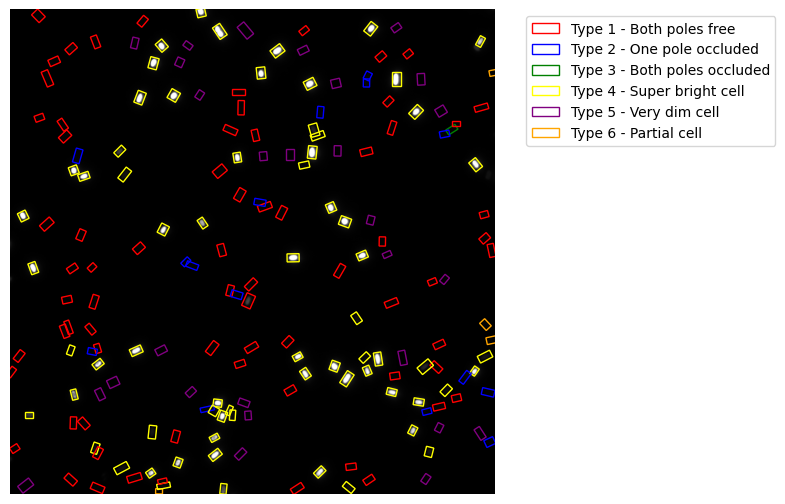

In [ ]:
imshow_with_boxes(im, y, legend=True, legend_loc='best');

## CLAHE

Tackling low signal problem: Let's take a look at an image with labels.

How CLAHE (Contrast Limited Adaptive Histogram Equalization) works:

1. Basic Principle:
- Unlike regular histogram equalization which works on the entire image at once, CLAHE works on small regions (tiles) of the image
- This local approach helps maintain local details and contrast

2. Step-by-Step Process:
   - The image is divided into small tiles (defined by tile_grid_size)
   - For each tile:
     - A local histogram is computed
     - The histogram is clipped at a predetermined value (clip_limit) to prevent noise amplification
     - Histogram equalization is applied to that tile
   - Bilinear interpolation is used to eliminate artificial boundaries between tiles

3. Key Advantages:
   - Better handling of local contrast
   - Prevents over-amplification of noise (through clipping)
   - Preserves edges and local details
   - Works well with varying brightness levels in different image regions

4. Parameters Impact:
   - clip_limit: Higher values allow more contrast enhancement but may increase noise
   - tile_grid_size: Smaller tiles give more local enhancement but might make the image look "patchy"

In [ ]:
im.shape

(1952, 1952)

TODO: Why are we using `uint16`? Maybe should change it to float32 or bfloat16?

In [ ]:
im.dtype

dtype('uint16')

In [ ]:
#| export
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(image)
    return enhanced

In [ ]:
#| export
def compare_ims(img1, img2, im1_title='img1', im2_title='img2', cmap='gray'):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(img1, cmap=cmap)
    plt.title(im1_title)
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(img2, cmap=cmap)
    plt.title(im2_title)
    plt.axis('off')

    plt.show()

In [ ]:
#| export
def compare_ims_with_boxes(img1, img2, boxes1=None, boxes2=None, im1_title='img1', im2_title='img2', 
                           legend=None, legend_loc='best'):
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    
    if boxes1 is not None: 
        imshow_with_boxes(img1, boxes1, ax=axs[0], legend=legend, legend_loc=legend_loc)
    else:
        axs[0].imshow(img1, cmap='gray')
        axs[0].axis('off')
    axs[0].set_title(im1_title)
    
    if boxes2 is not None:
        imshow_with_boxes(img2, boxes2, ax=axs[1], legend=legend, legend_loc=legend_loc)
    else:
        axs[1].imshow(img2, cmap='gray')
        axs[1].axis('off')
    axs[1].set_title(im2_title)
    
    plt.tight_layout()
    plt.show()
    return fig, axs

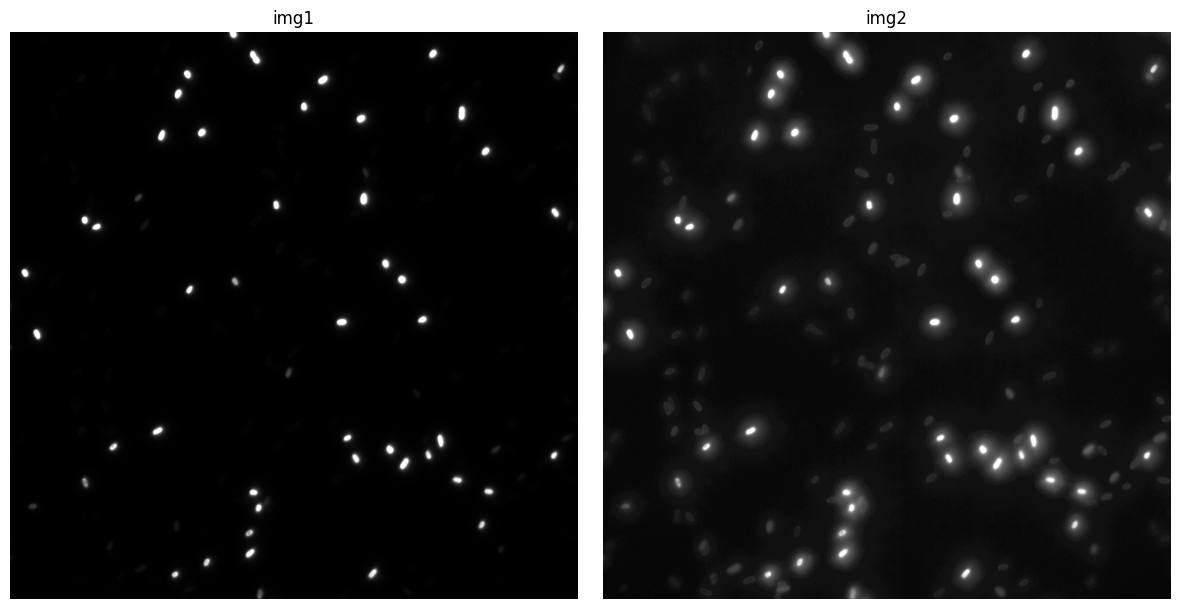

In [ ]:
enh = apply_clahe(im, clip_limit=10.1, tile_grid_size=(8,8))
compare_ims_with_boxes(im, enh);

Here's what it looks like with labels:

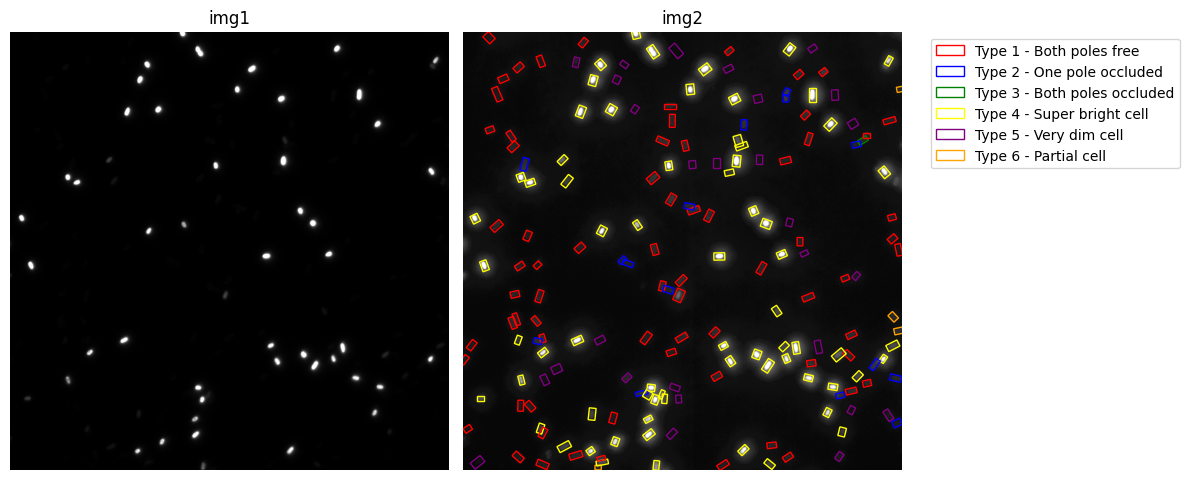

In [ ]:
compare_ims_with_boxes(im, enh, boxes2=y, legend=True);

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()